# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import defaultdict
from itertools import product
import seaborn as sns

from main import run_single_tournament

pygame 2.6.1 (SDL 2.28.4, Python 3.13.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Resultados

## Gráficos de barra

In [11]:
def plot_final_scores_by_mode_and_rounds(modes, round_grid):
    """
    Gera e salva gráficos de barras com a pontuação final de cada agente, para cada modo.
    """
    fixed_order = None  # Ordem fixa dos agentes

    for mode in modes:
        for n_rounds in round_grid:        
            scores, _, _ = run_single_tournament(render=False, mode=mode, rl_params=None, n_full_rounds=n_rounds)
            agents_dict = dict(scores)

            # Definir a ordem fixa na primeira vez
            if fixed_order is None:
                fixed_order = sorted(agents_dict.keys())

            # Organizar os pontos de acordo com a ordem fixa
            points = [agents_dict.get(agent, 0) for agent in fixed_order]

            plt.figure(figsize=(8, 6))
            plt.bar(fixed_order, points)
            plt.title(f'Pontuação Final por Agente\nModo: {mode}, Rodadas: {n_rounds}')
            plt.xlabel('Agentes')
            plt.ylabel('Pontuação Final')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()  

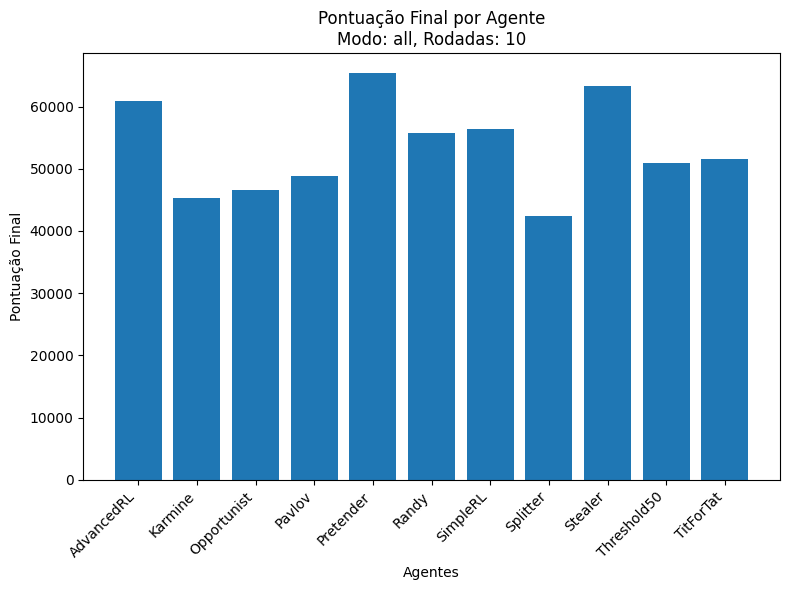

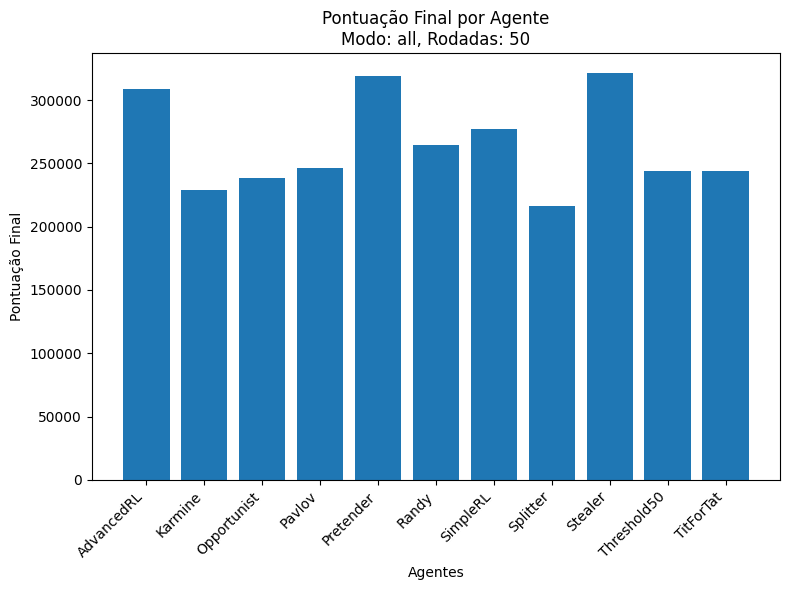

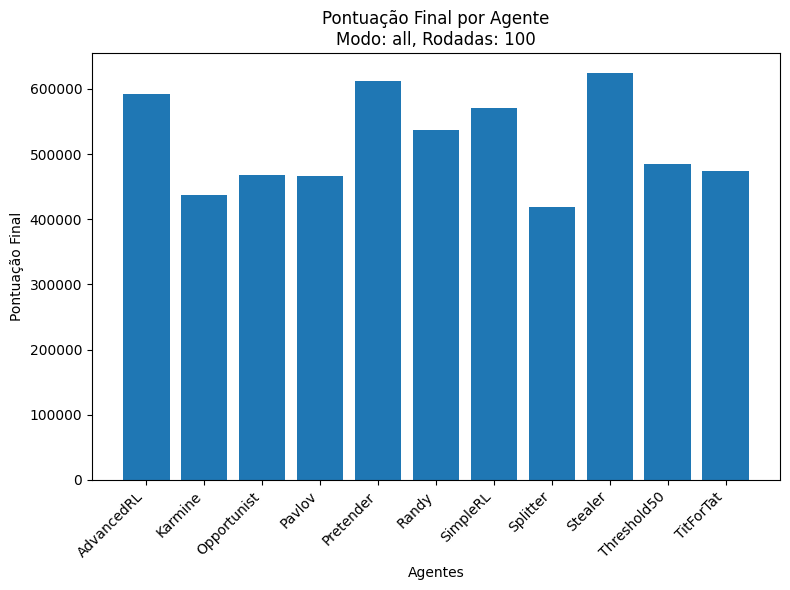

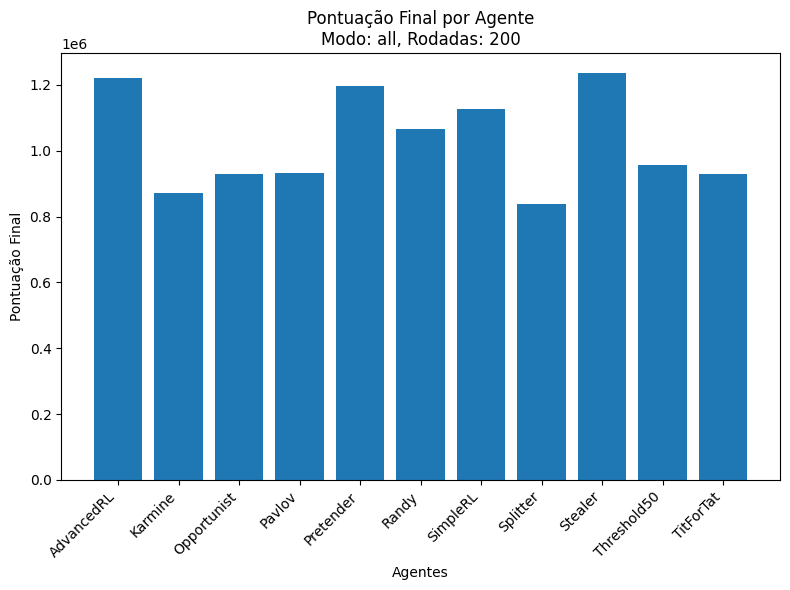

In [15]:
modes = [
    'all',
    # 'simple',
    # 'difficult',
    # 'very_difficult',
    # 'karma_aware',
    # 'opportunists',
    # 'three_karmines',
    # 'pavlov_vs_tft',
    # 'threshold_mix'
]
round_grid = [10, 50, 100, 200]
plot_final_scores_by_mode_and_rounds(modes, round_grid)

## Curvas de aprendizado

In [4]:
def plot_cumulative_learning_curves(modes, rl_params=None):
    plt.figure(figsize=(6, 4))
    for mode in modes:
        _, rewards, _ = run_single_tournament(render=False, mode=mode, rl_params=rl_params)
        cumulative = np.cumsum(rewards)
        plt.plot(range(1, len(cumulative) + 1), cumulative, label=mode)
    
    plt.xlabel('Rodada')
    plt.ylabel('Recompensa acumulada')
    plt.title('Curvas de Aprendizado por Modo')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_avarage_learning_curves(modes, rl_params=None):    
    plt.figure(figsize=(6, 4))
    for mode in modes:
        _, rewards, _ = run_single_tournament(render=False, mode=mode, rl_params=rl_params)
        rewards = np.array(rewards)
        
        rounds = np.arange(1, len(rewards) + 1)
        mean_rewards = rewards.cumsum() / rounds
        plt.plot(rounds, mean_rewards, label=mode)

    plt.xlabel('Rodada')
    plt.ylabel('Recompensa média por rodada')
    plt.title('Curvas de Aprendizado (recompensa média) por Modo')
    plt.legend()
    plt.tight_layout()
    plt.show()

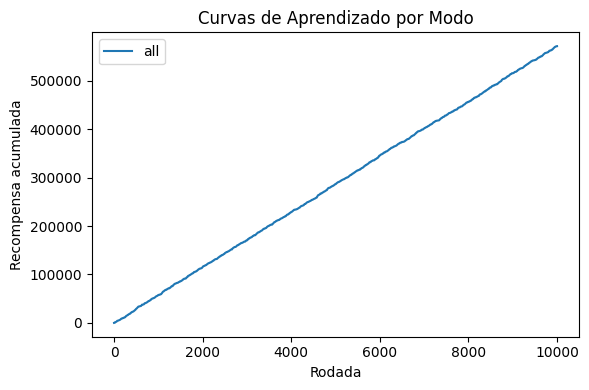

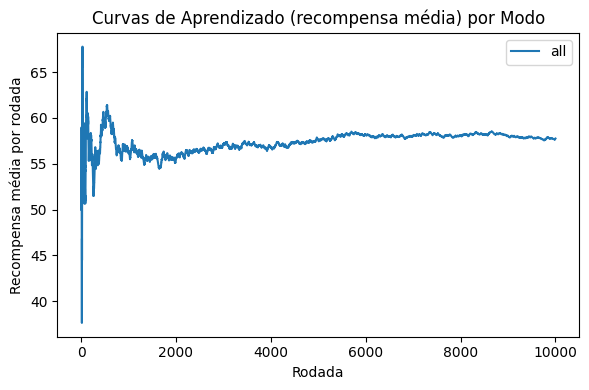

In [5]:

modes = [
    'all',
    # 'simple',
    # 'difficult',
    # 'very_difficult',
    # 'karma_aware',
    # 'opportunists',
    # 'three_karmines',
    # 'pavlov_vs_tft',
    # 'threshold_mix'
]
plot_cumulative_learning_curves(modes)
plot_avarage_learning_curves(modes)

## GridSearch

In [6]:
def grid_search(mode: str, param_grid: dict, repetitions: int = 3):
    results = []

    # para cada combinação de hiper‑parâmetros
    for alpha, gamma, epsilon in product(param_grid['alpha'], param_grid['gamma'], param_grid['epsilon']):
        scores_acc = []
        
        for _ in range(repetitions):            
            scores, _, _ = run_single_tournament(
                render=False,
                mode=mode,
                rl_params=(alpha, gamma, epsilon)
            )
            
            rl_score = next(score for name, score in scores if name.startswith('SimpleRL'))
            scores_acc.append(rl_score)
        
        mean_score = sum(scores_acc) / repetitions
        results.append({
            'alpha':      alpha,
            'gamma':      gamma,
            'epsilon':    epsilon,
            'mean_score': mean_score
        })
    
    return results

In [7]:
mode = 'all'
grid = {
    'alpha':   [0.1, 0.3, 0.5, 0.7, 0.9],
    'gamma':   [0.5, 0.7, 0.9, 0.99],
    'epsilon': [0.01, 0.05, 0.1, 0.2],
}
repetitions = 5

results = grid_search(
    mode=mode,
    param_grid=grid,
    repetitions=repetitions
)

In [8]:
df = pd.DataFrame(results)
df_top10 = df.nlargest(10, 'mean_score').reset_index(drop=True)

print("\nTop 10 combinações de hiperparâmetros (pelo score médio):\n")
print(
    df_top10.to_string(
        index=False,
        float_format="  %.2f".__mod__  # formata floats com 2 casas
    )
)


Top 10 combinações de hiperparâmetros (pelo score médio):

 alpha  gamma  epsilon  mean_score
  0.90   0.99     0.20   599992.96
  0.50   0.50     0.01   598820.53
  0.70   0.50     0.01   598616.48
  0.30   0.50     0.01   596662.83
  0.90   0.50     0.05   594713.67
  0.30   0.50     0.05   594184.21
  0.90   0.50     0.01   593911.59
  0.90   0.99     0.10   593610.41
  0.70   0.50     0.05   593503.71
  0.70   0.70     0.01   593441.60


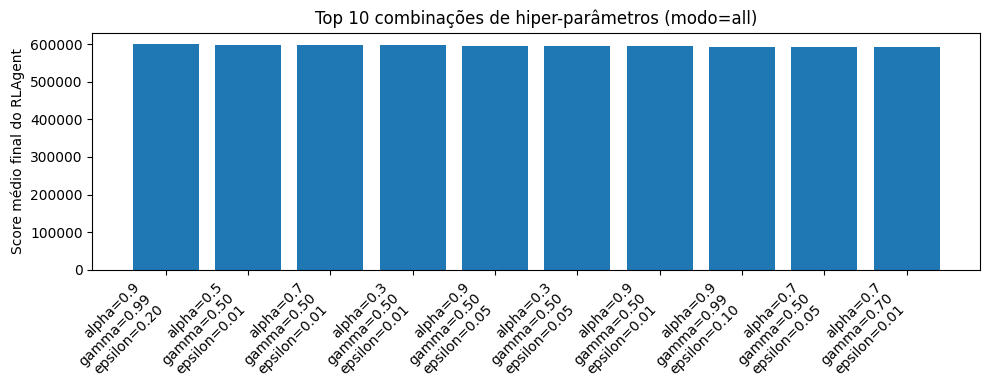

In [9]:
plt.figure(figsize=(10,4))
labels = [
    f"alpha={r.alpha:.1f}\ngamma={r.gamma:.2f}\nepsilon={r.epsilon:.2f}"
    for _, r in df_top10.iterrows()
]
plt.bar(labels, df_top10['mean_score'])
plt.xticks(rotation=45, ha='right')
plt.title(f"Top 10 combinações de hiper-parâmetros (modo={mode})")
plt.ylabel("Score médio final do RLAgent")
plt.tight_layout()
plt.show()

## Heatmap da q_table

In [10]:
def extract_q_table_dataframe(rl_agent):
    """
    Extrai a Q-table do agente RL como um DataFrame estruturado.
    
    Retorna um DataFrame com colunas:
    - Your_Karma
    - Opponent_Karma_Sign
    - Q_Split: valor Q da ação 'split'
    - Q_Steal: valor Q da ação 'steal'
    """
    q_data = []
    for state, q_values in rl_agent.Q.items():
        your_karma = state[0]
        opponent_karma_sign = state[1]
        q_split, q_steal = q_values
        q_data.append((your_karma, opponent_karma_sign, q_split, q_steal))
    
    return pd.DataFrame(q_data, columns=["Your_Karma", "Opponent_Karma_Sign", "Q_Split", "Q_Steal"])

In [11]:
def plot_heat_map_by_mode(modes, rl_params=None, action="Q_Steal"):
    """
    Para cada modo, executa o torneio, extrai a Q-table e plota o heatmap
    dos valores Q da ação especificada ('Q_Steal' ou 'Q_Split').
    """
    for mode in modes:
        _, _, rl_agent = run_single_tournament(render=False, mode=mode, rl_params=rl_params)

        q_df = extract_q_table_dataframe(rl_agent)

        # print(df.sort_values(by=["Rounds_Left_Sign", "Karma_Sign"]).to_string(index=False))

        # Verifica se a ação solicitada é válida
        if action not in ["Q_Split", "Q_Steal"]:
            raise ValueError("Ação deve ser 'Q_Split' ou 'Q_Steal'.")
               
        # Cria a tabela pivô: linhas = your_karma, colunas = opponent_karma_sign
        pivot = q_df.pivot_table(
            index="Your_Karma", 
            columns="Opponent_Karma_Sign", 
            values=action,
            aggfunc="mean"  # caso haja duplicatas
        )

        plt.figure(figsize=(8, 6))
        sns.heatmap(pivot, annot=True, fmt=".2f", cmap="coolwarm", center=0)
        plt.title(f"Heatmap dos Q-values para ação '{action[2:].lower()}' — modo: {mode}")
        plt.ylabel("Your_Karma")
        plt.xlabel("Opponent_Karma_Sign")
        plt.show()


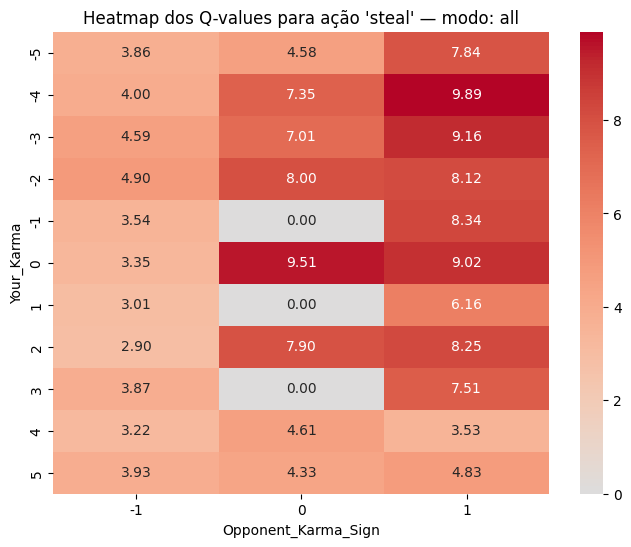

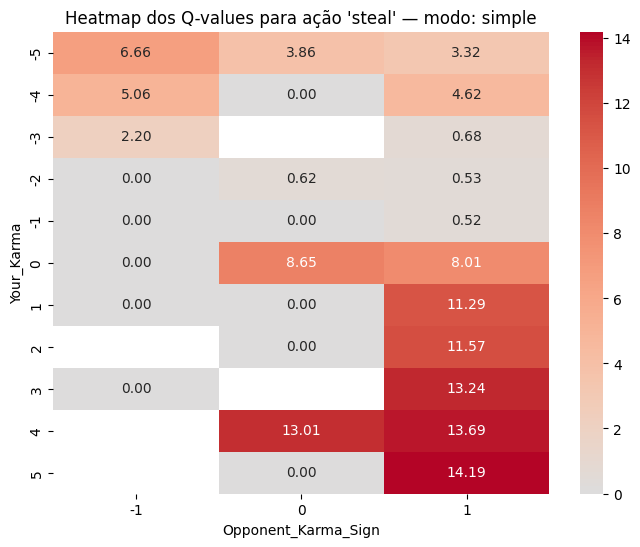

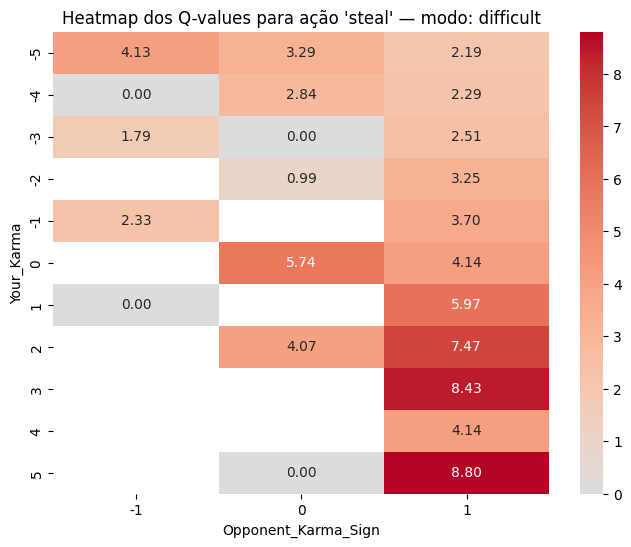

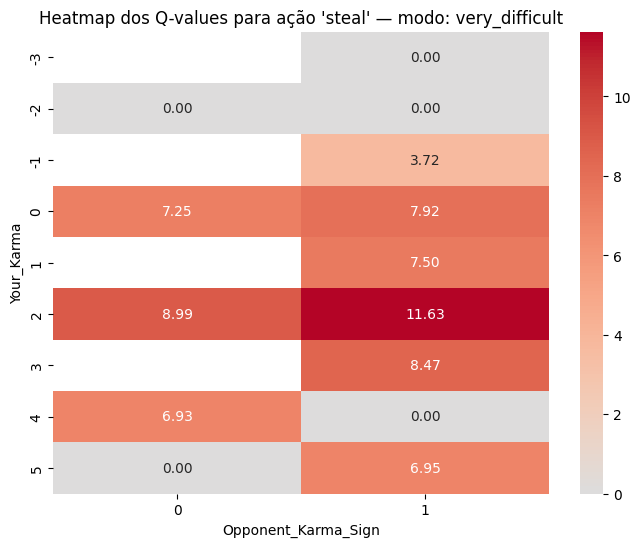

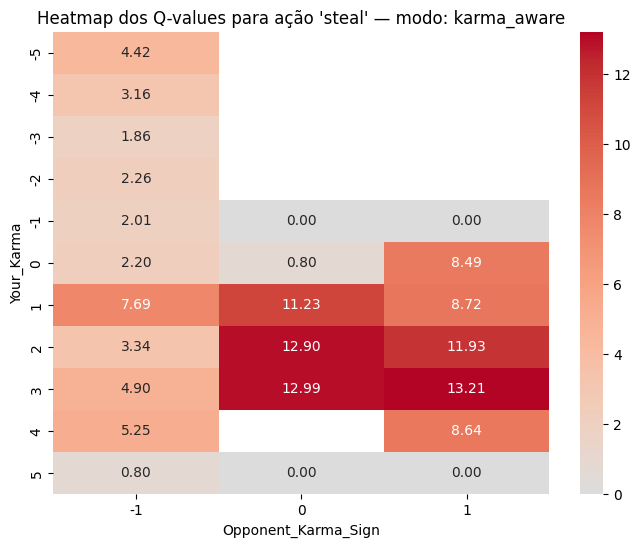

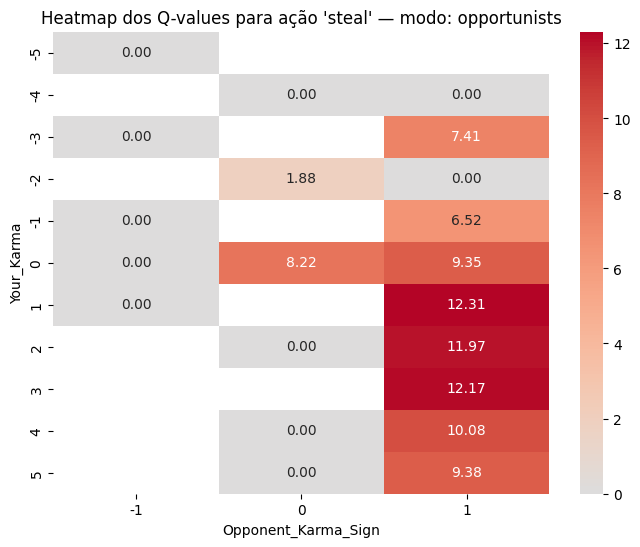

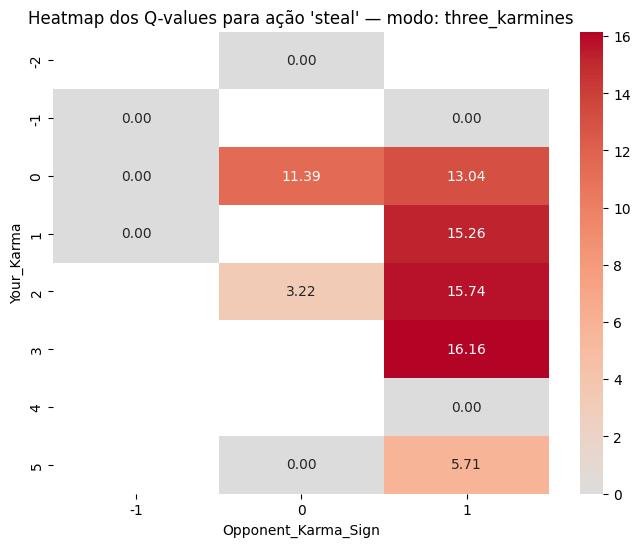

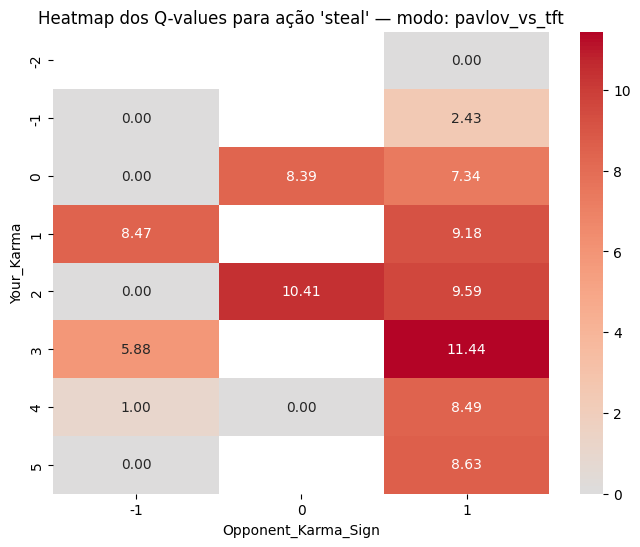

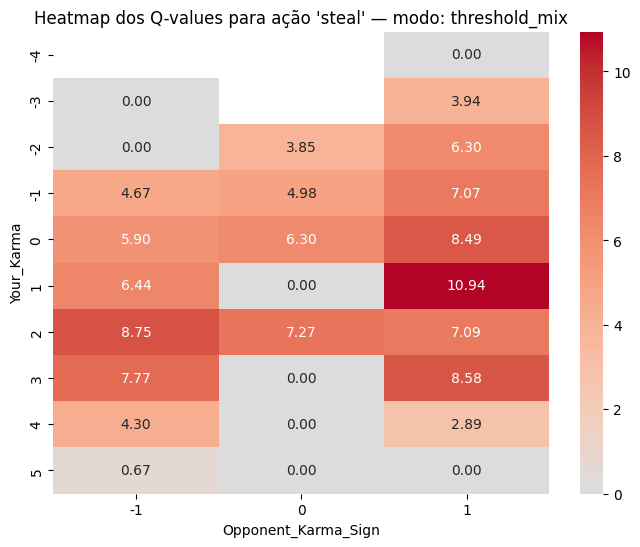

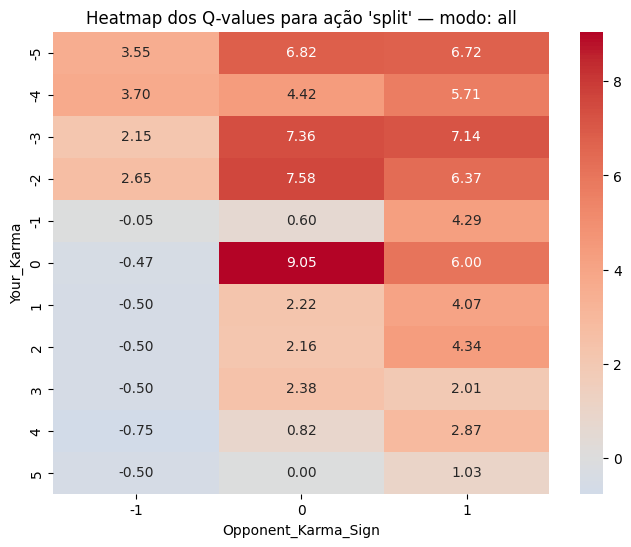

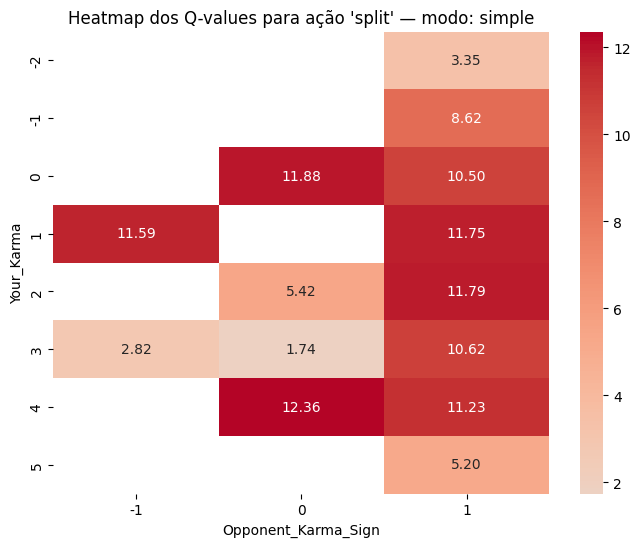

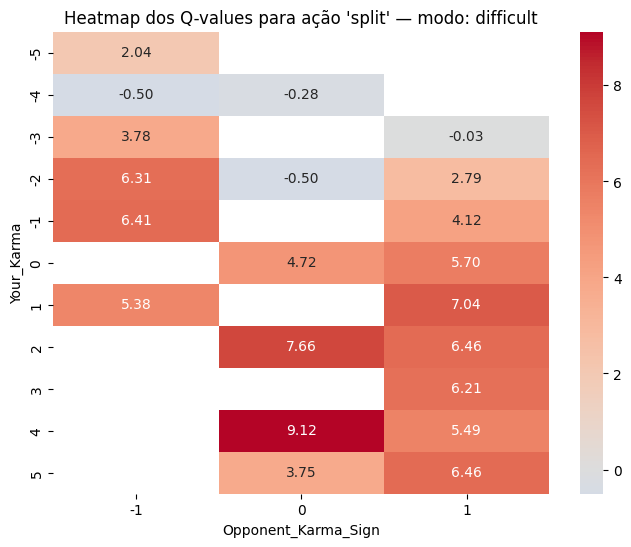

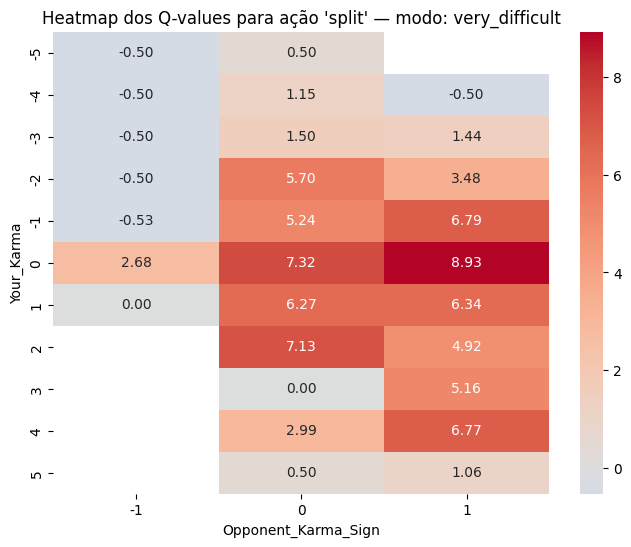

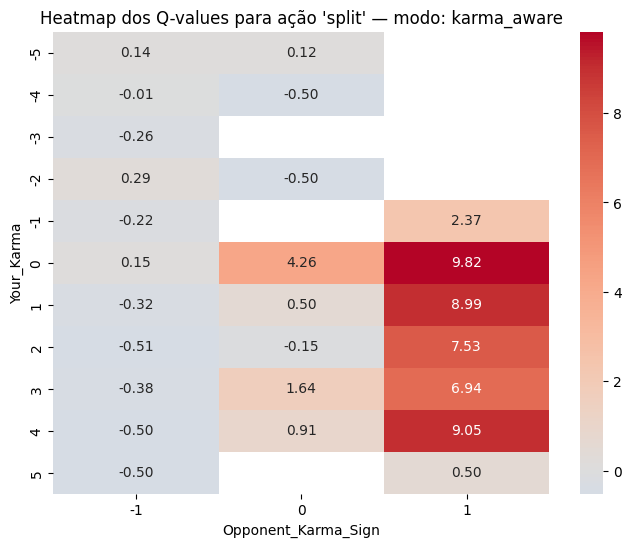

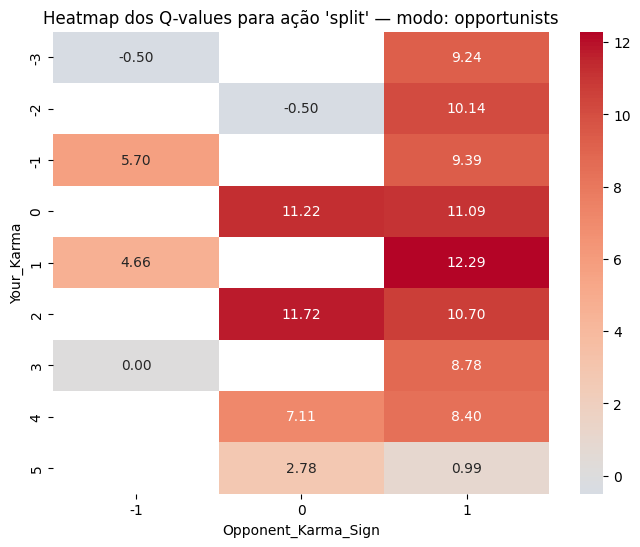

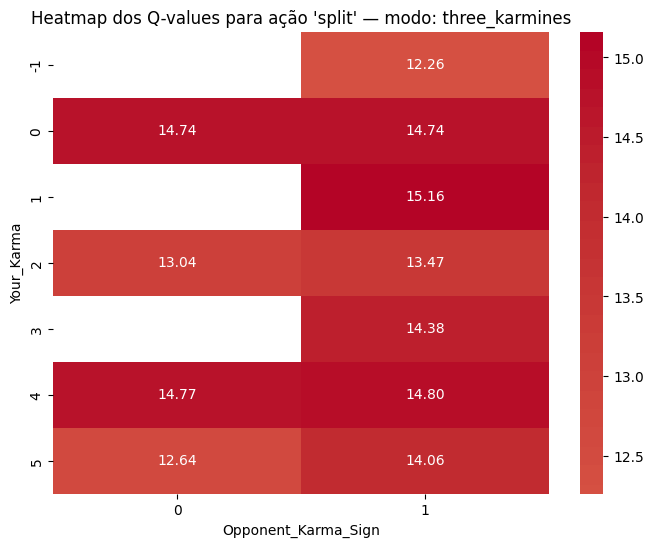

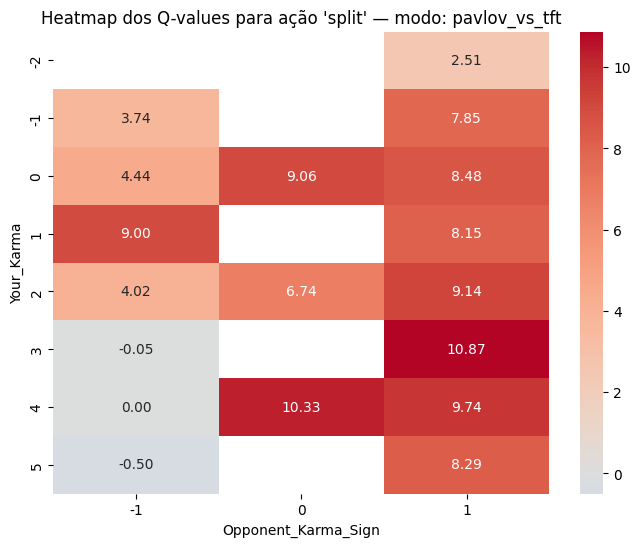

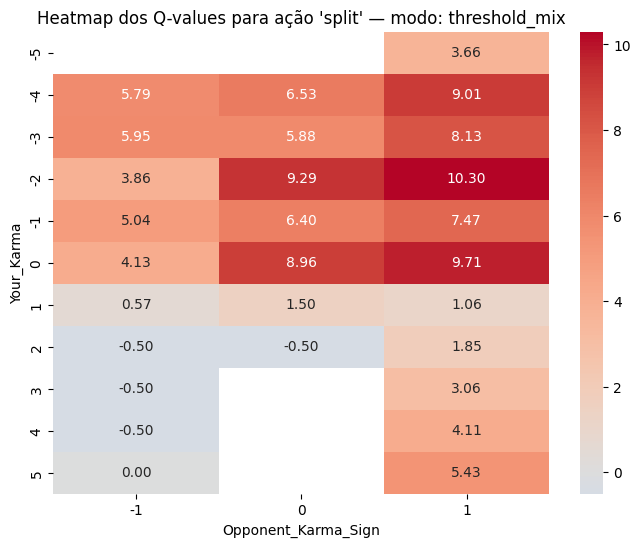

In [12]:
modes = [
    'all',
    'simple',
    'difficult',
    'very_difficult',
    'karma_aware',
    'opportunists',
    'three_karmines',
    'pavlov_vs_tft',
    'threshold_mix'
]
plot_heat_map_by_mode(modes, action="Q_Steal")
plot_heat_map_by_mode(modes, action="Q_Split")